In [85]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time
import sys
%matplotlib inline
import random
import copy
import logging
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import keras.backend as K
import tensorflow as tf
from tsfresh import extract_features
import tsfresh.feature_extraction.feature_calculators as features
from pandas import DataFrame


# Setup logging.
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='FFNN-Products.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)



In [78]:
tree_examples = DataFrame (columns  = ['ffnn','arima','lstm','length','kurtosis','energy','variance'], index = ['serie1','serie2','serie3'])
tree_examples

,ffnn,arima,lstm,length,kurtosis,energy,variance
serie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serie2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serie3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING , SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie):
        experimentx = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1, self.WINDOW))
        experimenty = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1,self.STEPS_AHEAD))
        cnt =  0
        cnt2 = 0
        #serie = serie.reset_index(drop = True)
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = serie[cnt]
                cnt += 1   
            #print(serie[cnt:cnt + self.STEPS_AHEAD], " \n")    
            valores = serie[cnt:cnt + self.STEPS_AHEAD]
            for h in range(len(valores)):
                experimenty[i][h] = valores[h]
            cnt = 0
            cnt2 += 1           
        return (experimentx, experimenty)
    
    def batch (self):
        training,testing = self.divide_testing()
        tex,tey = self.divide_validation(testing)
        tx,ty = self.divide_validation(training)        
        return (tx,ty) , (tex,tey)
Serie_1 = pd.read_excel("wti/WTI_mensual.xlsx")
Serie_1 = Serie_1.iloc[:, 1:2].values
Serie_1 = np.rot90(Serie_1, 2)
Serie_1
scaler = MinMaxScaler(feature_range = (0.1, 0.9))
Serie_1 = scaler.fit_transform(Serie_1)  
Serie_1


array([[0.22075938],
       [0.22427844],
       [0.22613058],
       [0.22248804],
       [0.2260071 ],
       [0.2193394 ],
       [0.20606575],
       [0.21612903],
       [0.21878376],
       [0.21137521],
       [0.20427535],
       [0.19871894],
       [0.19871894],
       [0.20069455],
       [0.21032567],
       [0.20625096],
       [0.20754746],
       [0.20155888],
       [0.20310233],
       [0.20902917],
       [0.21520296],
       [0.22322889],
       [0.2193394 ],
       [0.19803982],
       [0.15192159],
       [0.11753357],
       [0.1       ],
       [0.11802747],
       [0.12395431],
       [0.11457015],
       [0.10450687],
       [0.13383238],
       [0.126856  ],
       [0.12994289],
       [0.12827597],
       [0.14642692],
       [0.15142769],
       [0.13815404],
       [0.15192159],
       [0.15130421],
       [0.15531718],
       [0.16093533],
       [0.16760303],
       [0.15747801],
       [0.15661367],
       [0.15889798],
       [0.14994598],
       [0.138

In [84]:
Serie_2 = Serie_1.ravel()
Serie_2
serie_caracteristicas = {'value' : Serie_2}
serie_caracteristicas = DataFrame (serie_caracteristicas)
serie_caracteristicas
energy = features.abs_energy(serie_caracteristicas["value"])
length = features.length(serie_caracteristicas["value"])
kurtosis = features.kurtosis(serie_caracteristicas["value"])
variance = features.variance(serie_caracteristicas["value"])
tree_examples.loc['serie1'] = pd.Series({'energy':energy, 'length': length, 'kurtosis':kurtosis, 'variance':variance})
tree_examples

,ffnn,arima,lstm,length,kurtosis,energy,variance
serie1,NaN,NaN,NaN,427,-0.238592,52.85,0.0317806
serie2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serie3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.

        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated

        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.

        Args:
            count (int): Number of networks to generate, aka the
                size of the population

        Returns:
            (list): Population of network objects

        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.

        Args:
            pop (list): The population of networks

        Returns:
            (float): The average accuracy of the population

        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.

        Args:
            mother (dict): Network parameters
            father (dict): Network parameters

        Returns:
            (list): Two network objects

        """
        children = []
        for _ in range(2):

            child = {}

            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.

        Args:
            network (dict): The network parameters to mutate

        Returns:
            (Network): A randomly mutated network object

        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Mutate one of the params.
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])

        return network

    def evolve(self, pop):
        """Evolve a population of networks.

        Args:
            pop (list): A list of network parameters

        Returns:
            (list): The evolved population of networks

        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [60]:
class Network():
    """Represent a network and let us operate on it.

    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.

        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.

        Args:
            network (dict): The network parameters

        """
        self.network = network

    def train(self):
        """Train the network and record the accuracy.

        Args:
            dataset (str): Name of dataset to use.

        """
        if self.accuracy == 0.:
            self.accuracy = 1/train_and_score(self.network)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [61]:


# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)


def compile_model(network, nb_classes):
    """Compile a sequential model.

    Args:
        network (dict): the parameters of the network

    Returns:
        a compiled network.

    """
    # Get our network parameters.
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    i_neurons = network['i_neurons']
    activation = network['activation']
    optimizer = network['optimizer']

    model = Sequential()
    input_shape = (i_neurons, )
    
  

    # Add each layer.
    for i in range(nb_layers):

        # Need input shape for first layer.
        if i == 0:
            model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
        else:
            model.add(Dense(nb_neurons, activation=activation))

        model.add(Dropout(0.2))  # hard-coded dropout

    # Output layer.
    model.add(Dense(nb_classes, activation=activation))

    model.compile(loss= model_dice, optimizer=optimizer,metrics=['mean_squared_error'])

    return model

def train_and_score(network):
    """Train the model, return test loss.

    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating

    """
    batch_size = 1
    i_neurons = network['i_neurons']
    # Set defaults.
    serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)

    # Get the data.
    (x_train, y_train), (x_test, y_test) = serie1.batch()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    model = compile_model(network, 1)

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10000,  # using early stopping, so no real limit
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[early_stopper])

    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)

    return score[1]  # 1 is accuracy. 0 is loss.

In [62]:

def train_networks(networks):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks))
    for network in networks:
        network.train()
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices):
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if (i != generations - 1):
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])
    print(networks[:5])

def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    generations = 4  # Number of times to evole the population.
    population = 30  # Number of networks in each generation.

    nn_param_choices = {
        'nb_neurons': [4,6,8,10,12,16],
        'i_neurons': [4,6,12],
        'nb_layers': [1, 2],
        'activation': ['relu', 'tanh', 'sigmoid'],
        'optimizer': ['adam', 'sgd'],
    }

    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))

    generate(generations, population, nn_param_choices)



In [60]:
main()


    

  0%|          | 0/30 [00:00<?, ?it/s]

[0.04912565276026726, 0.04912565276026726]


  3%|▎         | 1/30 [00:14<07:00, 14.51s/it]

[0.05574319139122963, 0.05574319139122963]


  7%|▋         | 2/30 [00:44<09:00, 19.30s/it]

[0.01184595562517643, 0.005922977812588215]


 10%|█         | 3/30 [00:50<06:51, 15.23s/it]

[0.07869771867990494, 0.07869771867990494]


 13%|█▎        | 4/30 [00:56<05:21, 12.36s/it]

[0.07155121862888336, 0.07155121862888336]


 17%|█▋        | 5/30 [01:08<05:08, 12.32s/it]

[0.05415105074644089, 0.05415105074644089]


 20%|██        | 6/30 [01:28<05:48, 14.54s/it]

[0.014475088566541672, 0.007237544283270836]


 23%|██▎       | 7/30 [01:38<05:06, 13.31s/it]

[0.0017191924853250384, 0.0008595962426625192]


 27%|██▋       | 8/30 [01:46<04:12, 11.49s/it]

[0.07213524729013443, 0.036067623645067215]


 30%|███       | 9/30 [02:09<05:18, 15.18s/it]

[0.010671528056263924, 0.010671528056263924]


 33%|███▎      | 10/30 [02:20<04:33, 13.69s/it]

[0.05628244951367378, 0.05628244951367378]


 37%|███▋      | 11/30 [02:36<04:36, 14.55s/it]

[0.05503234639763832, 0.05503234639763832]


 40%|████      | 12/30 [03:09<05:59, 19.97s/it]

[0.10417701303958893, 0.052088506519794464]


 43%|████▎     | 13/30 [03:19<04:48, 16.96s/it]

[0.10835951566696167, 0.054179757833480835]


 47%|████▋     | 14/30 [03:25<03:41, 13.83s/it]

[0.07414617389440536, 0.07414617389440536]


 50%|█████     | 15/30 [03:35<03:11, 12.75s/it]

[0.05869946628808975, 0.05869946628808975]


 53%|█████▎    | 16/30 [03:42<02:32, 10.91s/it]

[0.11252855509519577, 0.056264277547597885]


 57%|█████▋    | 17/30 [03:54<02:24, 11.10s/it]

[0.0005435189232230186, 0.0002717594616115093]


 60%|██████    | 18/30 [04:01<01:59,  9.93s/it]

[0.08476133644580841, 0.08476133644580841]


 63%|██████▎   | 19/30 [04:10<01:45,  9.63s/it]

[0.005910598207265139, 0.0029552991036325693]


 67%|██████▋   | 20/30 [04:15<01:22,  8.27s/it]

[0.005609808024019003, 0.0028049040120095015]


 70%|███████   | 21/30 [04:21<01:09,  7.77s/it]

[0.098699189722538, 0.049349594861269]


 73%|███████▎  | 22/30 [04:35<01:15,  9.47s/it]

[0.0702928751707077, 0.03514643758535385]


 77%|███████▋  | 23/30 [04:55<01:28, 12.69s/it]

[0.05594484880566597, 0.05594484880566597]


 80%|████████  | 24/30 [05:28<01:52, 18.82s/it]

[0.04978920891880989, 0.04978920891880989]


 83%|████████▎ | 25/30 [05:38<01:21, 16.26s/it]

[0.05412712320685387, 0.05412712320685387]


 87%|████████▋ | 26/30 [05:53<01:03, 15.82s/it]

[0.01815575361251831, 0.009077876806259155]


 90%|█████████ | 27/30 [06:01<00:40, 13.40s/it]

[0.007471489254385233, 0.0037357446271926165]


 93%|█████████▎| 28/30 [06:11<00:25, 12.51s/it]

[0.010149534791707993, 0.010149534791707993]


 97%|█████████▋| 29/30 [06:22<00:12, 12.08s/it]

[0.046485792845487595, 0.046485792845487595]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.0015081699239090085, 0.0007540849619545043]


 47%|████▋     | 14/30 [00:08<00:09,  1.61it/s]

[0.003153641242533922, 0.001576820621266961]


 50%|█████     | 15/30 [00:40<02:27,  9.86s/it]

[0.0037934172432869673, 0.0018967086216434836]


 53%|█████▎    | 16/30 [00:56<02:43, 11.69s/it]

[0.03977147862315178, 0.03977147862315178]


 57%|█████▋    | 17/30 [01:14<02:58, 13.75s/it]

[0.05860216170549393, 0.029301080852746964]


 60%|██████    | 18/30 [01:44<03:41, 18.48s/it]

[0.02174929901957512, 0.01087464950978756]


 63%|██████▎   | 19/30 [01:51<02:46, 15.14s/it]

[0.02004323899745941, 0.010021619498729706]


 67%|██████▋   | 20/30 [01:57<02:03, 12.34s/it]

[0.006744962651282549, 0.0033724813256412745]


 70%|███████   | 21/30 [02:11<01:55, 12.85s/it]

[0.009631521068513393, 0.004815760534256697]


 73%|███████▎  | 22/30 [02:23<01:39, 12.50s/it]

[0.008396385237574577, 0.004198192618787289]


 77%|███████▋  | 23/30 [02:32<01:21, 11.60s/it]

[0.007693271618336439, 0.0038466358091682196]


 80%|████████  | 24/30 [02:43<01:09, 11.51s/it]

[0.014777073636651039, 0.0073885368183255196]


 83%|████████▎ | 25/30 [02:58<01:02, 12.57s/it]

[0.0038670760113745928, 0.0019335380056872964]


 87%|████████▋ | 26/30 [03:05<00:43, 10.76s/it]

[0.011926667764782906, 0.005963333882391453]


 90%|█████████ | 27/30 [03:13<00:29,  9.96s/it]

[0.010521847754716873, 0.005260923877358437]


 93%|█████████▎| 28/30 [03:29<00:23, 11.89s/it]

[0.00895210262387991, 0.004476051311939955]


 97%|█████████▋| 29/30 [03:41<00:11, 11.75s/it]

[0.008901502937078476, 0.004450751468539238]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.005725333001464605, 0.0028626665007323027]


 50%|█████     | 15/30 [00:10<00:10,  1.46it/s]

[0.02079744078218937, 0.010398720391094685]


 53%|█████▎    | 16/30 [00:23<01:02,  4.46s/it]

[0.007701463997364044, 0.003850731998682022]


 57%|█████▋    | 17/30 [00:35<01:27,  6.75s/it]

[0.007094775326550007, 0.0035473876632750034]


 60%|██████    | 18/30 [00:49<01:45,  8.79s/it]

[0.00491289421916008, 0.00245644710958004]


 63%|██████▎   | 19/30 [01:07<02:06, 11.54s/it]

[0.01636042818427086, 0.00818021409213543]


 67%|██████▋   | 20/30 [01:21<02:03, 12.32s/it]

[0.010923371650278568, 0.005461685825139284]


 70%|███████   | 21/30 [01:37<02:00, 13.43s/it]

[0.01612735539674759, 0.008063677698373795]


 73%|███████▎  | 22/30 [01:47<01:40, 12.58s/it]

[0.07849276065826416, 0.07849276065826416]


 77%|███████▋  | 23/30 [01:54<01:15, 10.81s/it]

[0.017453445121645927, 0.008726722560822964]


 80%|████████  | 24/30 [02:07<01:08, 11.47s/it]

[0.0006560926558449864, 0.0003280463279224932]


 83%|████████▎ | 25/30 [02:24<01:05, 13.07s/it]

[0.0020660036243498325, 0.0010330018121749163]


 87%|████████▋ | 26/30 [02:46<01:03, 15.89s/it]

[0.014061512425541878, 0.014061512425541878]


 90%|█████████ | 27/30 [02:53<00:39, 13.16s/it]

[0.0206659696996212, 0.0103329848498106]


 93%|█████████▎| 28/30 [03:01<00:22, 11.45s/it]

[0.009331334382295609, 0.004665667191147804]


 97%|█████████▋| 29/30 [03:13<00:11, 11.82s/it]

[0.005301314406096935, 0.0026506572030484676]


  0%|          | 0/30 [00:00<?, ?it/s]

[0.055374033749103546, 0.055374033749103546]


 47%|████▋     | 14/30 [00:26<00:29,  1.86s/it]

[0.0053151994943618774, 0.0026575997471809387]


 50%|█████     | 15/30 [00:39<01:20,  5.39s/it]

[0.0008254984859377146, 0.0004127492429688573]


 53%|█████▎    | 16/30 [00:54<01:53,  8.08s/it]

[0.018179630860686302, 0.009089815430343151]


 57%|█████▋    | 17/30 [01:10<02:17, 10.59s/it]

[0.0163554847240448, 0.0081777423620224]


 60%|██████    | 18/30 [01:17<01:55,  9.59s/it]

[0.0016283972654491663, 0.0008141986327245831]


 63%|██████▎   | 19/30 [01:30<01:56, 10.55s/it]

[0.005152083933353424, 0.002576041966676712]


 67%|██████▋   | 20/30 [01:49<02:11, 13.13s/it]

[0.014573520980775356, 0.007286760490387678]


 70%|███████   | 21/30 [02:01<01:53, 12.66s/it]

[0.00034683055127970874, 0.00017341527563985437]


 73%|███████▎  | 22/30 [02:19<01:54, 14.37s/it]

[0.0025759469717741013, 0.0012879734858870506]


 77%|███████▋  | 23/30 [02:30<01:33, 13.35s/it]

[0.004143738187849522, 0.002071869093924761]


 80%|████████  | 24/30 [02:43<01:19, 13.21s/it]

[0.0018665576353669167, 0.0009332788176834583]


 83%|████████▎ | 25/30 [02:56<01:05, 13.15s/it]

[0.007538807578384876, 0.003769403789192438]


 87%|████████▋ | 26/30 [03:12<00:55, 13.92s/it]

[0.002682494930922985, 0.0013412474654614925]


 90%|█████████ | 27/30 [03:22<00:38, 12.96s/it]

[0.0017515583895146847, 0.0008757791947573423]


 93%|█████████▎| 28/30 [03:42<00:29, 14.91s/it]

[0.0017732628621160984, 0.0008866314310580492]


 97%|█████████▋| 29/30 [03:56<00:14, 14.59s/it]

[0.059632208198308945, 0.059632208198308945]


100%|██████████| 30/30 [04:16<00:00, 16.27s/it]


[<__main__.Network object at 0x000001D70FCC4F60>, <__main__.Network object at 0x000001D6E4E8DCC0>, <__main__.Network object at 0x000001D704831C88>, <__main__.Network object at 0x000001D70E8AF978>, <__main__.Network object at 0x000001D6E4E8DB38>]


In [86]:
early_stopper = EarlyStopping(patience=20)
logging.info('entrada')
batch_size = 1
i_neurons = 30
nb_layers = 2
nb_neurons = 12
activation = 'relu'
optimizer = 'sgd'
nb_classes = 1



model = Sequential()
input_shape = (i_neurons, )



# Add each layer.
for i in range(nb_layers):

    # Need input shape for first layer.
    if i == 0:
        model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
    else:
        model.add(Dense(nb_neurons, activation=activation))

    model.add(Dropout(0.2))  # hard-coded dropout

# Output layer.
model.add(Dense(nb_classes, activation=activation))

model.compile(loss= 'mean_squared_error', optimizer=optimizer,metrics= ['mean_squared_error'])


# Set defaults.
serie1 = TimeSeriesNN3(nb_classes,45,Serie_1,i_neurons)

# Get the data.
(x_train, y_train), (x_test, y_test) = serie1.batch()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10000,  # using early stopping, so no real limit
          verbose=0,
          validation_data=(x_test, y_test),
          callbacks=[early_stopper])

score = model.evaluate(x_test, y_test, verbose=0)
print(score)
logging.info('salida')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
[0.003145660739392042, 0.003145660739392042]


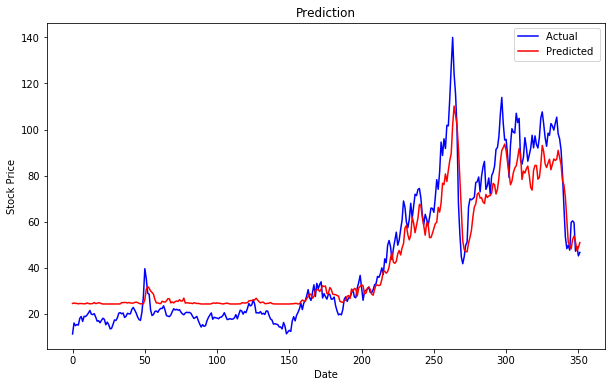

In [87]:
predictions = model.predict(x_train)  
predictions = scaler.inverse_transform(predictions) 
labelsf = scaler.inverse_transform( y_train) 
plt.figure(figsize=(10,6))  
plt.plot(labelsf, color='blue', label='Actual ')  
plt.plot(predictions , color='red', label='Predicted ')  
plt.title('Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

In [92]:
predictions = model.predict(x_test)  
np.mean((predictions -  y_test)**2)

0.0031456606453685266

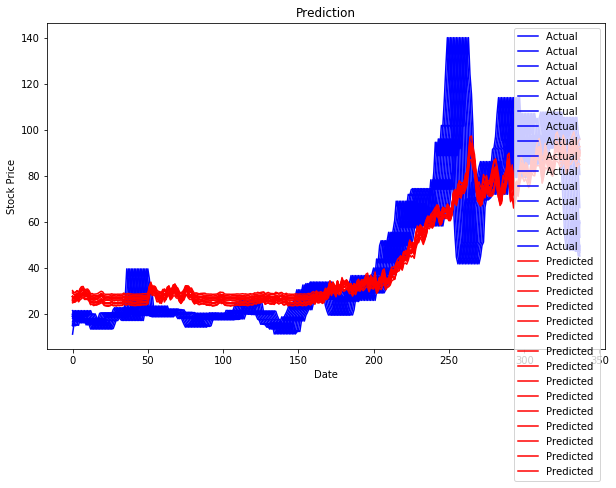

In [182]:
predictions = model.predict(x_train)  
predictions = scaler.inverse_transform(predictions) 
labelsf = scaler.inverse_transform( y_train) 
plt.figure(figsize=(10,6))  
plt.plot(labelsf, color='blue', label='Actual ')  
plt.plot(predictions , color='red', label='Predicted ')  
plt.title('Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

In [161]:
y_test

array([[0.44956012, 0.49345578, 0.46017904, 0.46659978, 0.48789937,
        0.43887946, 0.35010032, 0.31602099, 0.36775737, 0.38893348,
        0.40696095, 0.43023615, 0.36596697, 0.39665072, 0.38016669]])

(15,)
[60.397293 61.508656 63.77372  58.895847 62.194187 63.708145 62.64091
 59.23445  63.2512   59.92987  60.77421  63.570347 59.761734 62.11913
 59.818897]


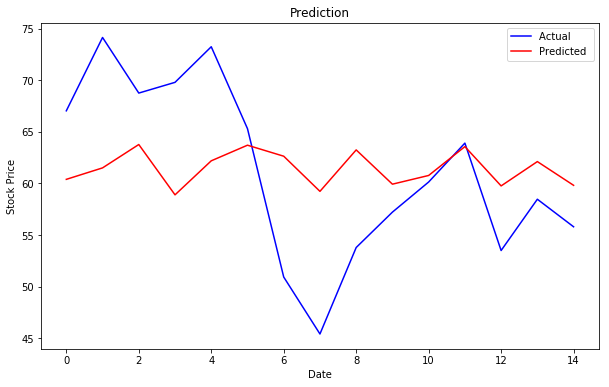

In [186]:
predictions = model.predict(x_test)  
predictions = scaler.inverse_transform(predictions) 
predictions = predictions.reshape(15,)
print(predictions.shape)
labelsf = scaler.inverse_transform( y_test) 
labelsf = labelsf.reshape(15,)
print(predictions)
plt.figure(figsize=(10,6))  
plt.plot(labelsf, color='blue', label='Actual ')  
plt.plot(predictions , color='red', label='Predicted ')  
plt.title('Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

In [188]:
(((predictions - labelsf) **2).mean())**(1/2)

8.028295066570605

In [67]:
def error_fun_list (lista_predicciones, lista_real):
    cnt_total = 0
    cnt_aciertos = 0
    for i in range (0, len(lista_predicciones)):
        if lista_predicciones[i] <= (lista_real[i] + 0.1) and lista_predicciones[i] >= (lista_real[i] - 0.1):
            cnt_aciertos += 1
        cnt_total += 1
    accuracy = cnt_aciertos/cnt_total
    print ("aciertos totales",cnt_aciertos, "total", cnt_total )
    print ("accuracy", accuracy)
    return accuracy

In [98]:
predictions = model.predict(x_train) 
predictions
y_train
error_fun_list(predictions,y_train)

aciertos totales 291 total 315
accuracy 0.9238095238095239


0.9238095238095239

In [133]:
serie1 = TimeSeriesNN3(6,100,Serie_1,10)
(x_train, y_train), (x_test, y_test) = serie1.batch()
print(x_train) 
print(y_train)

[[0.69669702]
 [0.67169316]
 [0.68311468]
 [0.56988733]
 [0.56019447]
 [0.57933323]]  

[[0.67169316]
 [0.68311468]
 [0.56988733]
 [0.56019447]
 [0.57933323]
 [0.63125482]]  

[[0.68311468]
 [0.56988733]
 [0.56019447]
 [0.57933323]
 [0.63125482]
 [0.60483099]]  

[[0.56988733]
 [0.56019447]
 [0.57933323]
 [0.63125482]
 [0.60483099]
 [0.56809693]]  

[[0.56019447]
 [0.57933323]
 [0.63125482]
 [0.60483099]
 [0.56809693]
 [0.58458095]]  

[[0.57933323]
 [0.63125482]
 [0.60483099]
 [0.56809693]
 [0.58458095]
 [0.60254669]]  

[[0.63125482]
 [0.60483099]
 [0.56809693]
 [0.58458095]
 [0.60254669]
 [0.63755209]]  

[[0.60483099]
 [0.56809693]
 [0.58458095]
 [0.60254669]
 [0.63755209]
 [0.60396666]]  

[[0.56809693]
 [0.58458095]
 [0.60254669]
 [0.63755209]
 [0.60396666]
 [0.63594691]]  

[[0.58458095]
 [0.60254669]
 [0.63755209]
 [0.60396666]
 [0.63594691]
 [0.61267171]]  

[[0.60254669]
 [0.63755209]
 [0.60396666]
 [0.63594691]
 [0.61267171]
 [0.60347276]]  

[[0.63755209]
 [0.60396666]
 [0.

 [0.19803982]]  

[[0.20902917]
 [0.21520296]
 [0.22322889]
 [0.2193394 ]
 [0.19803982]
 [0.15192159]]  

[[0.21520296]
 [0.22322889]
 [0.2193394 ]
 [0.19803982]
 [0.15192159]
 [0.11753357]]  

[[0.22322889]
 [0.2193394 ]
 [0.19803982]
 [0.15192159]
 [0.11753357]
 [0.1       ]]  

[[0.2193394 ]
 [0.19803982]
 [0.15192159]
 [0.11753357]
 [0.1       ]
 [0.11802747]]  

[[0.19803982]
 [0.15192159]
 [0.11753357]
 [0.1       ]
 [0.11802747]
 [0.12395431]]  

[[0.15192159]
 [0.11753357]
 [0.1       ]
 [0.11802747]
 [0.12395431]
 [0.11457015]]  

[[0.11753357]
 [0.1       ]
 [0.11802747]
 [0.12395431]
 [0.11457015]
 [0.10450687]]  

[[0.1       ]
 [0.11802747]
 [0.12395431]
 [0.11457015]
 [0.10450687]
 [0.13383238]]  

[[0.11802747]
 [0.12395431]
 [0.11457015]
 [0.10450687]
 [0.13383238]
 [0.126856  ]]  

[[0.12395431]
 [0.11457015]
 [0.10450687]
 [0.13383238]
 [0.126856  ]
 [0.12994289]]  

[[0.11457015]
 [0.10450687]
 [0.13383238]
 [0.126856  ]
 [0.12994289]
 [0.12827597]]  

[[0.10450687]


 [0.19773113]]  

[[0.20476925]
 [0.19797808]
 [0.21137521]
 [0.21081957]
 [0.19773113]
 [0.19834851]]  

[[0.19797808]
 [0.21137521]
 [0.21081957]
 [0.19773113]
 [0.19834851]
 [0.20359623]]  

[[0.21137521]
 [0.21081957]
 [0.19773113]
 [0.19834851]
 [0.20359623]
 [0.18032104]]  

[[0.21081957]
 [0.19773113]
 [0.19834851]
 [0.20359623]
 [0.18032104]
 [0.16643   ]]  

[[0.19773113]
 [0.19834851]
 [0.20359623]
 [0.18032104]
 [0.16643   ]
 [0.15568761]]  

[[0.19834851]
 [0.20359623]
 [0.18032104]
 [0.16643   ]
 [0.15568761]
 [0.15815712]]  

[[0.20359623]
 [0.18032104]
 [0.16643   ]
 [0.15568761]
 [0.15815712]
 [0.15593456]]  

[[0.18032104]
 [0.16643   ]
 [0.15568761]
 [0.15815712]
 [0.15593456]
 [0.16988733]]  

[[0.16643   ]
 [0.15568761]
 [0.15815712]
 [0.15593456]
 [0.16988733]
 [0.19810156]]  

[[0.15568761]
 [0.15815712]
 [0.15593456]
 [0.16988733]
 [0.19810156]
 [0.20415188]]  

[[0.15815712]
 [0.15593456]
 [0.16988733]
 [0.19810156]
 [0.20415188]
 [0.19192777]]  

[[0.15593456]


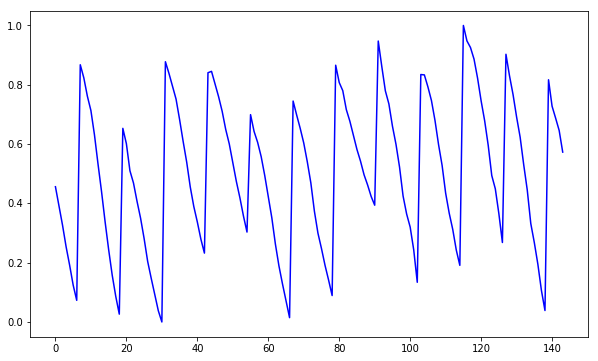

In [65]:
serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)